In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

import sys
sys.path.insert(0, "/Users/feldlime/Documents/Projects/RecTools/RecTools")

In [24]:
import os
import warnings
from pathlib import Path

import pandas as pd
import numpy as np

from rectools.metrics import MAP, calc_metrics, MeanInvUserFreq, Serendipity
from rectools.models import ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset

from rectools.models.dssm import DSSMModel
from rectools.models.dssm_no_interactions import DSSMModelNoInteractions
from rectools.models.dssm_double_interactions import DSSMModelDoubleInteractions
from rectools.dataset.torch_datasets import DSSMDataset, DSSMDatasetNoInteractions, DSSMDatasetDoubleInteractions


## Load and preprocess data: Kion

In [5]:
%%time
!wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip -O data_original.zip
!unzip -o data_original.zip
!rm data_original.zip

Archive:  data_original.zip
   creating: data_original/
  inflating: data_original/interactions.csv  
  inflating: __MACOSX/data_original/._interactions.csv  
  inflating: data_original/users.csv  
  inflating: __MACOSX/data_original/._users.csv  
  inflating: data_original/items.csv  
  inflating: __MACOSX/data_original/._items.csv  
CPU times: user 161 ms, sys: 68.7 ms, total: 230 ms
Wall time: 9.6 s


In [6]:
DATA_PATH = Path("data_original")

users = pd.read_csv(DATA_PATH / 'users.csv')
items = pd.read_csv(DATA_PATH / 'items.csv')
interactions = (
    pd.read_csv(DATA_PATH / 'interactions.csv', parse_dates=["last_watch_dt"])
    .rename(columns={"last_watch_dt": Columns.Datetime})
)

In [7]:
%%time
# Process interactions
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)

# Split to train / test
max_date = interactions[Columns.Datetime].max()
train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()
train.drop(train.query("total_dur < 300").index, inplace=True)
cold_users = set(test[Columns.User]) - set(train[Columns.User])
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)
test_users = test[Columns.User].unique()
catalog=train[Columns.Item].unique()

# Process user features to the form of a flatten dataframe
users.fillna('Unknown', inplace=True)
users = users.loc[users[Columns.User].isin(train[Columns.User])].copy()
user_features_frames = []
for feature in ["sex", "age", "income"]:
    feature_frame = users.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)

# Process item features to the form of a flatten dataframe
items = items.loc[items[Columns.Item].isin(train[Columns.Item])].copy()
items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"
item_features = pd.concat((genre_feature, content_feature))

CPU times: user 2.45 s, sys: 693 ms, total: 3.14 s
Wall time: 3.31 s


In [8]:
user_features.head()

,id,value,feature
0,973171,М,sex
1,962099,М,sex
3,721985,Ж,sex
4,704055,Ж,sex
5,1037719,М,sex


In [9]:
item_features.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


## Datasets

In [10]:
dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
    item_features_df=item_features,
    cat_item_features=["genre", "content_type"],
)

### Metrics

In [11]:
metrics_name = {
    'MAP': MAP,
    'MIUF': MeanInvUserFreq,
    'Serendipity': Serendipity
    

}
metrics = {}
for metric_name, metric in metrics_name.items():
    for k in (10,):
        metrics[f'{metric_name}@{k}'] = metric(k=k)

## Grid Search for best pure iALS model params

In [44]:
K_RECOS = 10

In [12]:
model_classic = DSSMModel(
    dataset_type=DSSMDataset,
    verbose=1,
    
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
model_no_interactions = DSSMModelNoInteractions(
    dataset_type=DSSMDatasetNoInteractions,
    verbose=1,
    dataloader_num_workers=4,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
model_double_interactions = DSSMModelDoubleInteractions(
    dataset_type=DSSMDatasetDoubleInteractions,
    verbose=1,
    dataloader_num_workers=4,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
%%time
model_double_interactions.fit(dataset)

AttributeError: type object 'DSSMDatasetDoubleInteractions' has no attribute 'from_dataset'

In [ ]:
results = []
dataset = dataset_no_features

for alpha in alphas:
    for regularization in regularizations:
        for n_factors in factors:
            model_name = f"no_features_factors_{n_factors}_alpha_{alpha}_reg_{regularization}"
            model = make_base_model(factors=n_factors, regularization=regularization, alpha=alpha)
            model.fit(dataset)
            recos = model.recommend(
                users=test_users,
                dataset=dataset,
                k=K_RECOS,
                filter_viewed=True,
            )
            metric_values = calc_metrics(metrics, recos, test, train, catalog)
            metric_values["model"] = model_name
            results.append(metric_values)

In [145]:
pure_df = pd.DataFrame(results).set_index("model").sort_values(by=["MAP@10", "Serendipity@10"], ascending=False)
pure_df.head(5)

,MAP@1,MAP@5,MAP@10,MIUF@1,MIUF@5,MIUF@10,Serendipity@1,Serendipity@5,Serendipity@10,with_features
model,,,,,,,,,,
no_features_factors_32_alpha_10_reg_0.5,0.023853,0.044661,0.050860,5.122939,5.864645,6.319260,0.000107,0.000126,0.000128,False
no_features_factors_32_alpha_10_reg_0.01,0.023117,0.042483,0.049064,5.140355,5.880019,6.311438,0.000106,0.000125,0.000127,False
no_features_factors_32_alpha_10_reg_0.1,0.022661,0.041494,0.048325,5.220894,5.960500,6.353801,0.000109,0.000128,0.000129,False
no_features_factors_64_alpha_10_reg_0.01,0.020317,0.036539,0.041775,6.010125,6.590613,6.917891,0.000219,0.000206,0.000203,False
no_features_factors_64_alpha_10_reg_0.5,0.020408,0.036451,0.041736,6.095905,6.655192,6.991212,0.000232,0.000212,0.000209,False


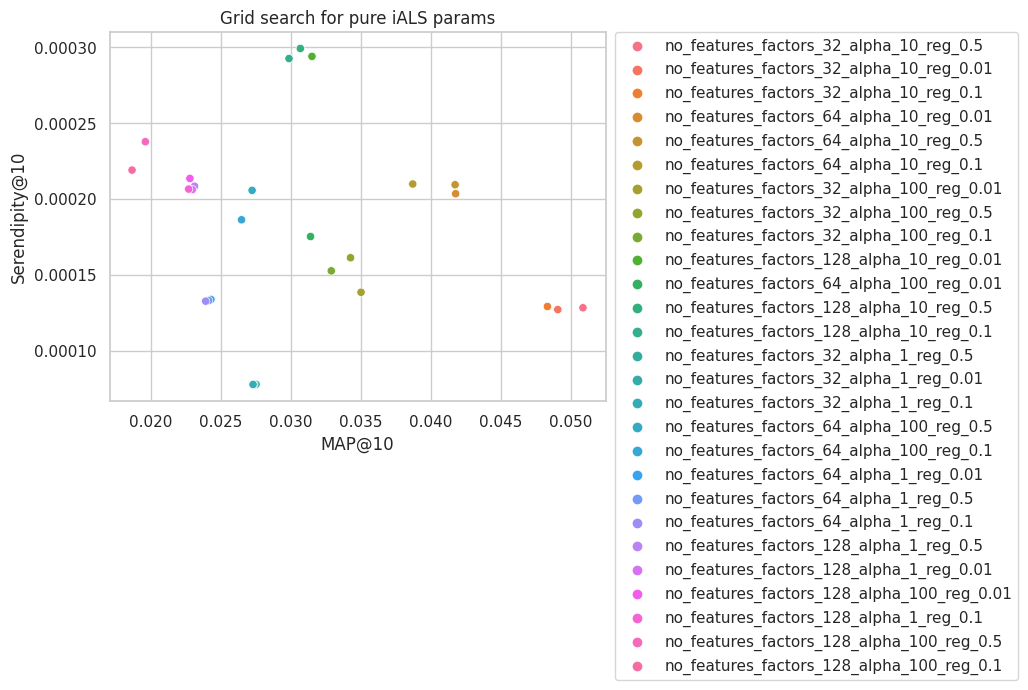

In [250]:
sns.scatterplot(data = pure_df, x="MAP@10", y="Serendipity@10", hue="model", legend=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Grid search for pure iALS params")
plt.show()

We achieved maximum MAP@10: `0.05`. 

From the plot we can clearly see that trying to achieve higher Serendipity metric leads to decrease in MAP. This is a classical trade-off. Lets' see if we can increase both metrics simultaneously, introducing features to the model

Lets' see best models params:

In [143]:
# Best params for MAP@10
pure_df.set_index("model").sort_values("MAP@10").tail(1)

,MAP@1,MAP@5,MAP@10,MIUF@1,MIUF@5,MIUF@10,Serendipity@1,Serendipity@5,Serendipity@10
model,,,,,,,,,
no_features_factors_32_alpha_10_reg_0.5,0.023853,0.044661,0.05086,5.122939,5.864645,6.31926,0.000107,0.000126,0.000128


In [144]:
# Best params for Serendipity@10
pure_df.set_index("model").sort_values("Serendipity@10").tail(1)

,MAP@1,MAP@5,MAP@10,MIUF@1,MIUF@5,MIUF@10,Serendipity@1,Serendipity@5,Serendipity@10
model,,,,,,,,,
no_features_factors_128_alpha_10_reg_0.5,0.015226,0.026761,0.030691,7.189521,7.565286,7.750308,0.000412,0.000338,0.000299


Here we can see that both max MAP and max Serendipity models have the same params for alpha and regularization. Let's fix them but keep all dimension size options for further research. This way we have 3 best models from pure iALS and try to add features to them.

## Add different feature selections to 3 best iALS models

In [171]:
# Best grid search params for pure iALS models
factors_options = (32, 64, 128)
ALPHA = 10
REG = 0.5

# We have two options for training iALS with features in RecTools
fit_features_together = (True, False)

# We have datasets with different feature selections
feature_datasets.keys()

dict_keys(['full_features', 'item_features', 'user_features', 'biases'])

In [ ]:
features_results = []
for dataset_name, dataset in feature_datasets.items():
    for n_factors in factors_options:
        for features_option in fit_features_together:
            model_name = f"{dataset_name}_factors_{n_factors}_fit_together_{features_option}"
            model = make_base_model(factors = n_factors, regularization=REG, alpha=ALPHA, fit_features_together=features_option)
            model.fit(dataset)
            recos = model.recommend(
                users=test_users,
                dataset=dataset,
                k=K_RECOS,
                filter_viewed=True,
            )
            metric_values = calc_metrics(metrics, recos, test, train, catalog)
            metric_values["model"] = model_name
            features_results.append(metric_values)

In [244]:
features_df = (
    pd.DataFrame(features_results)
    .set_index("model")
    .sort_values(by=["MAP@10", "Serendipity@10"], ascending=False)
)
features_df.head(5)

,MAP@1,MAP@5,MAP@10,MIUF@1,MIUF@5,MIUF@10,Serendipity@1,Serendipity@5,Serendipity@10
model,,,,,,,,,
full_features_factors_128_fit_together_True,0.040123,0.069483,0.076887,3.658149,4.369860,5.116690,0.000042,0.000049,0.000055
full_features_factors_64_fit_together_True,0.040797,0.069343,0.076602,3.599685,4.269495,4.986737,0.000035,0.000040,0.000046
full_features_factors_32_fit_together_True,0.040904,0.069000,0.076101,3.492285,4.162145,4.882946,0.000029,0.000036,0.000039
biases_factors_128_fit_together_False,0.035941,0.067140,0.074253,3.600921,3.945118,4.577787,0.000067,0.000076,0.000088
biases_factors_64_fit_together_False,0.035555,0.064373,0.072245,3.479163,4.028714,4.648506,0.000029,0.000045,0.000061


Let's visualise all of our research on the same plot to summarize results

## Visualise all results

In [237]:
# prepare info for summary plot
no_features_best_models = [
    "no_features_factors_128_alpha_10_reg_0.5", 
    "no_features_factors_64_alpha_10_reg_0.5",
    "no_features_factors_32_alpha_10_reg_0.5"
]

pure_df["step"] = "1. pure iALS no features grid search"
pure_df.loc[pure_df.index.isin(no_features_best_models), "step"] = "2. pure iALS no features best models"
features_df["step"] = "3. iALS with user / item features"
all_df = pd.concat([features_df, pure_df])


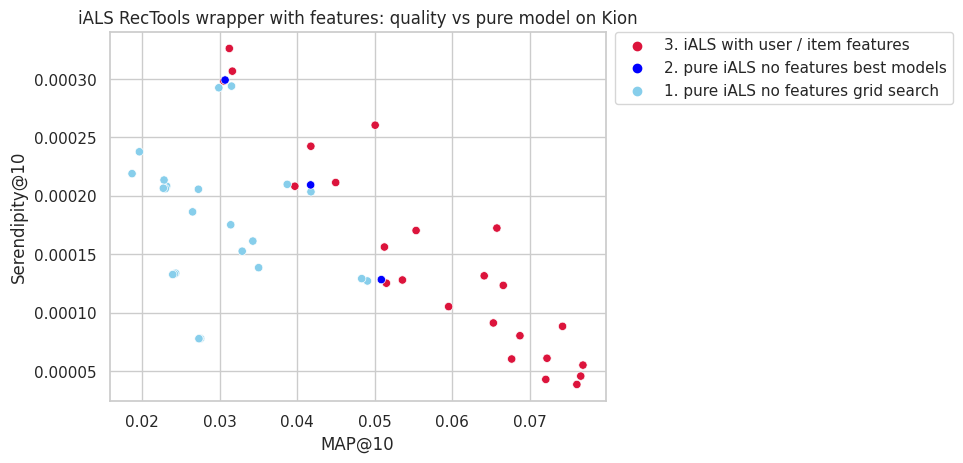

In [246]:
sns.scatterplot(data = all_df, x="MAP@10", y="Serendipity@10", hue="step", 
                palette=["crimson", "blue", "skyblue"])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("iALS RecTools wrapper with features: quality vs pure model on Kion")
plt.show()

## Summary on our benchmark
- Almost all of our feature selection options increased quality of the pure iALS best models.
- With features we achieved maximum for MAP@10 `0.077`! **This is a 50% increase from pure model best result**.
- We didn't simply increase MAP trading off Serendipity. Instead many of our feature options raised both metrics simultanuosly, which is a strong evidence of better performing algorithms.

Important notes:
- We skipped tuning optimal weights of interactions for iALS training 
- We skipped tuning number of iterations for iALS training
- We didn't preprocess features
- We didn't do actual feature selection and tested only quick subsets of features
- We didn't tune params again after adding features to training

## Technical details on RecTools implementation of iALS with features

In pure iALS model latent factors are initialized with random values.

When we train RecTools iALS wrapper on dataset with features, we add explicit user and/or item features to embeddings. After adding some number of item explicit features to the matrix of item embeddings, we also add the same number of columns to user embeddings matrix. These added columns are user factors paired to explicit item factors. We do the same for explicit user factors and item factors paired to them.

Technical moments:
- Paired factors are trained. Explicit features remain untouched
- We can train paried factors together with latent factors (`fit_features_together=True`) or after training latent factors (`fit_features_together=False`)
- Explicit features are converted to `dense` format before training. Remember to keep reasonable amount of data to avoid memory problems
- Training and inference is proceeded with `implicit` library methods

Full scheme:

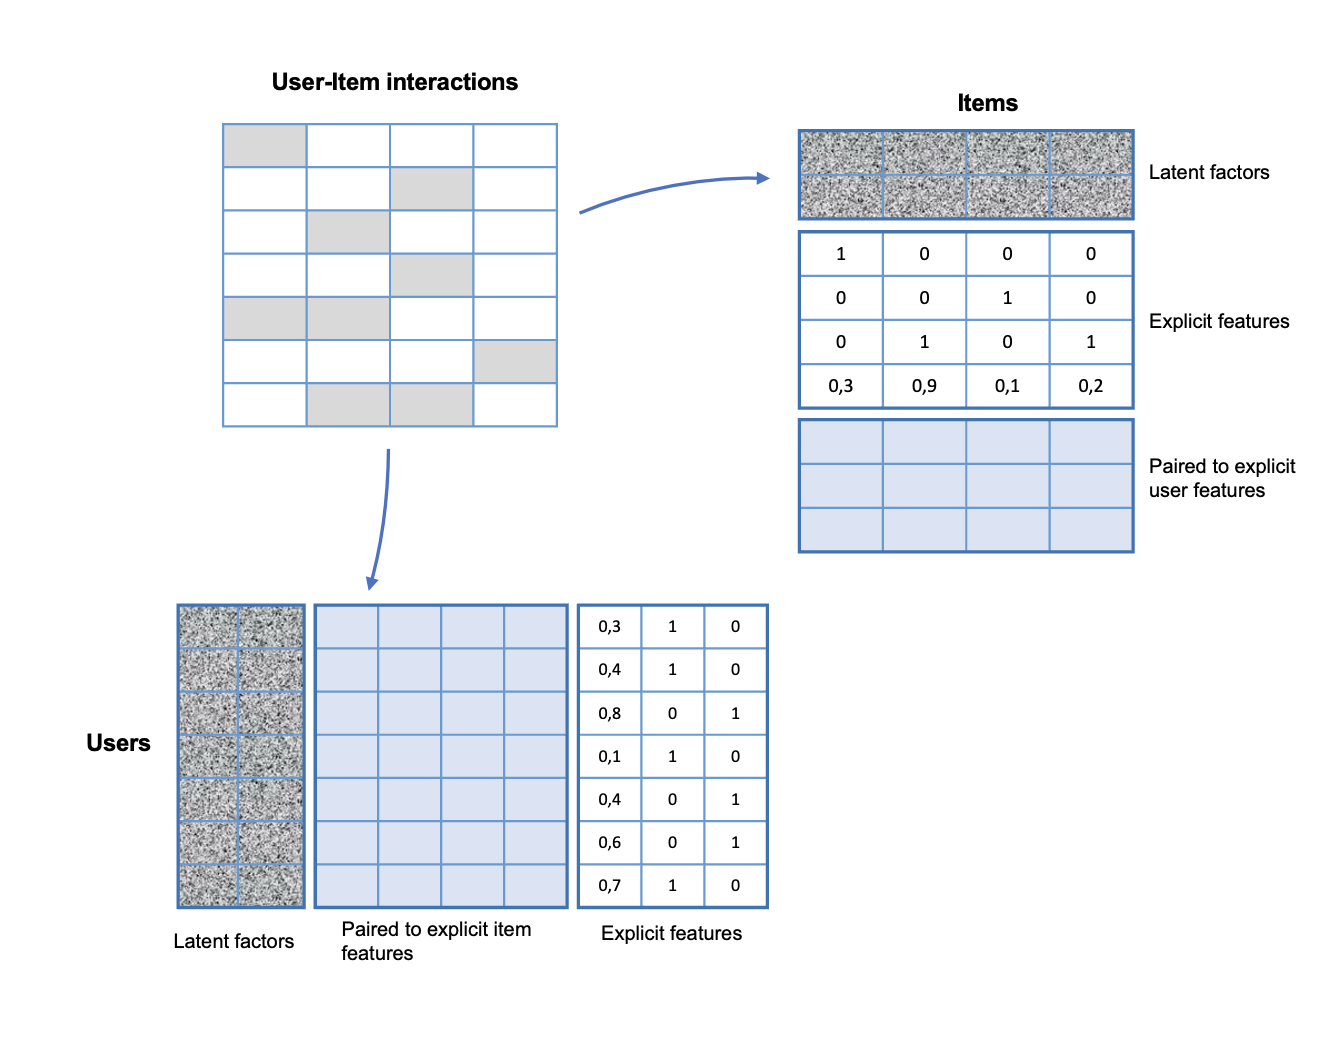